# **Backtracking Solver**

A simple brute-force approach to solving a Sudoku puzzle. The algorithm will iterate over all possible solutions and by applying constraints this can reduce the overall time complexity of the solver. Additional tricks can be implemented to further reduce the time needed to solve this problem.

In [1]:
import time
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

## **1: Grid Definition**

In [2]:
class SudokuGrid:
    def __init__(self, grid: str):
        values: list[int] = [int(s) for s in grid]
        self.dim_total: int = int(np.sqrt(len(values)))
        self.dim_boxes: int = int(np.sqrt(self.dim_total))
        self.shape: tuple[int, int] = (self.dim_total, self.dim_total)
        self.cells: np.ndarray = np.asarray(values, dtype=np.uint8).reshape(self.shape)
        self.frozen: np.ndarray = self.cells.copy()

    def __str__(self) -> str:
        return self.cells.__str__()

    def __repr__(self) -> str:
        return self.cells.__repr__()

    def get_row_by_index(self, i: int, _: int) -> np.ndarray:
        return self.cells[i, :]

    def get_col_by_index(self, _: int, j: int) -> np.ndarray:
        return self.cells[:, j]

    def get_box_by_index(self, i: int, j: int) -> np.ndarray:
        i = (i // self.dim_boxes) * self.dim_boxes
        j = (j // self.dim_boxes) * self.dim_boxes
        return self.cells[i : i + self.dim_boxes, j : j + self.dim_boxes]

    def cell_is_valid(self, i: int, j: int) -> bool:
        row: np.ndarray = self.get_row_by_index(i, j)
        col: np.ndarray = self.get_col_by_index(i, j)
        box: np.ndarray = self.get_box_by_index(i, j)
        if np.unique(row[row != 0]).size != row[row != 0].size:
            return False
        elif np.unique(col[col != 0]).size != col[col != 0].size:
            return False
        elif np.unique(box[box != 0]).size != box[box != 0].size:
            return False
        return True

    def is_valid(self) -> bool:
        dim: int = self.dim_boxes
        for i in range(self.dim_total):
            row: np.ndarray = self.get_row_by_index(i, _)
            if np.unique(row[row != 0]).size != row[row != 0].size:
                return False
            col: np.ndarray = self.get_col_by_index(_, i)
            if np.unique(col[col != 0]).size != col[col != 0].size:
                return False
            box: np.ndarray = self.get_box_by_index(i // dim * dim, i % dim * dim)
            if np.unique(box[box != 0]).size != box[box != 0].size:
                return False
        return True

    def is_complete(self) -> bool:
        return self.is_valid() and np.sum(self.cells == 0) == 0

## **2. Subspace Definition**

To save future work, a subspace of possible values are defined for each cell to reduce the need for complex hierarchical extensions of inheriting the algorithm to implement some optimisations. This subspace is simply a 3D matrix where each 2D cell contains available selections for that cell.

In [3]:
def setup_subspace(grid: SudokuGrid) -> np.ndarray:
    subspace: np.ndarray = np.zeros((*grid.shape, grid.dim_total + 1), dtype=np.bool_)
    subspace[:, :, 1:] = 1
    return subspace

## **3. Backtrack Algorithm**

In [206]:
def backtrack(grid: SudokuGrid, subspace: np.ndarray, i: int = 0, j: int = 0) -> bool:
    if i == grid.dim_total:
        return True
    j_upd: int = j + 1 if j + 1 < grid.dim_total else 0
    i_upd: int = i + 1 if j_upd == 0 else i

    if grid.frozen[i, j] != 0:
        return backtrack(grid, subspace, i_upd, j_upd)

    for (v,), valid_value_update in np.ndenumerate(subspace[i, j]):
        if valid_value_update:
            grid.cells[i, j] = v
            if grid.cell_is_valid(i, j):
                if backtrack(grid, subspace, i_upd, j_upd):
                    return True
    grid.cells[i, j] = 0
    return False

In [208]:
inp = "500670084407000630068000701000000209050980460679042518105869047796400852003720096"
grid: SudokuGrid = SudokuGrid(inp)
subspace: np.ndarray = setup_subspace(grid)
complete: bool = backtrack(grid, subspace)
grid, grid.is_complete()

(array([[5, 3, 2, 6, 7, 1, 9, 8, 4],
        [4, 1, 7, 2, 9, 8, 6, 3, 5],
        [9, 6, 8, 5, 3, 4, 7, 2, 1],
        [3, 8, 4, 1, 5, 6, 2, 7, 9],
        [2, 5, 1, 9, 8, 7, 4, 6, 3],
        [6, 7, 9, 3, 4, 2, 5, 1, 8],
        [1, 2, 5, 8, 6, 9, 3, 4, 7],
        [7, 9, 6, 4, 1, 3, 8, 5, 2],
        [8, 4, 3, 7, 2, 5, 1, 9, 6]], dtype=uint8),
 True)

## **3. Profiling the Solver**

In [223]:
FILEPATH: Path = Path().resolve().parent.parent / "data" / "sudoku.csv"


def setup_problems(filepath: Path = FILEPATH, num: int = 1000) -> list[tuple[str, str]]:
    problems: list[tuple[str, str]] = []
    with open(filepath, "r") as fp:
        for _ in range(num):
            problems.append(fp.readline().strip().split(","))
    return problems

In [ ]:
def solve_problems(problems: list[tuple[str, str]]) -> pd.DataFrame:
    _t_total: list[float] = []
    _t_setup: list[float] = []
    _t_solve: list[float] = []
    _t_check: list[float] = []
    _finished: list[bool] = []
    _solution: list[bool] = []
    _problemid: list[int] = []
    for i, (problem, solution) in enumerate(problems, 1):
        _problemid.append(i)
        t_total: float = time.time()
        grid: SudokuGrid = SudokuGrid(problem)
        t_setup: float = time.time()
        subspace: np.ndarray = setup_subspace(grid)
        _t_setup.append(time.time() - t_setup)
        t_solve: float = time.time()
        _finished.append(backtrack(grid, subspace))
        _t_solve.append(time.time() - t_solve)
        t_check: float = time.time()
        _solution.append(grid.is_complete())
        _t_check.append(time.time() - t_check)
        _t_total.append(time.time() - t_total)
        print(f"Solved ({_solution[-1]}): {_t_total[-1]:.4f}s")
    return pd.DataFrame(
        {
            "ProblemId": _problemid,
            "IsSolved": _solution,
            "IsFinished": _finished,
            "TotalTime": _t_total,
            "SetupTime": _t_setup,
            "SolveTime": _t_solve,
            "CheckTime": _t_check,
        }
    )


results: pd.DataFrame = solve_problems(setup_problems(num=100))

<Axes: xlabel='Profile', ylabel='Time'>

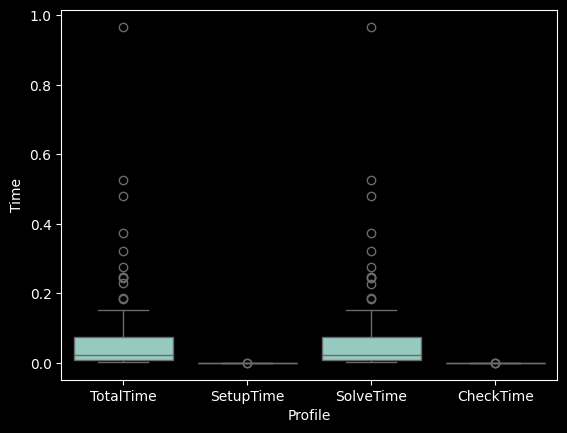

In [233]:
profile: pd.DataFrame = pd.melt(
    results,
    id_vars=["ProblemId", "IsSolved", "IsFinished"],
    value_vars=["TotalTime", "SetupTime", "SolveTime", "CheckTime"],
    value_name="Time",
    var_name="Profile",
)

sns.boxplot(profile, x="Profile", y="Time")

<Axes: ylabel='CheckTime'>

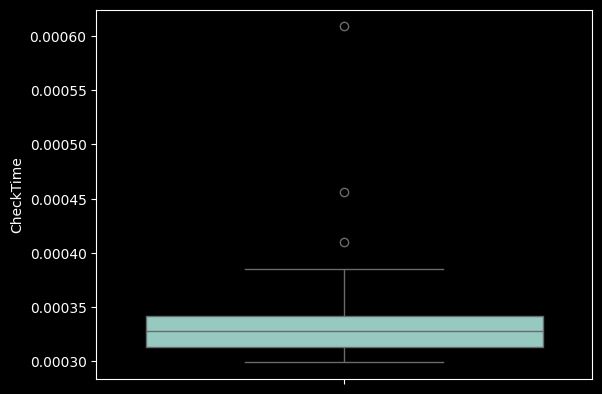

In [236]:
sns.boxplot(results, y="CheckTime")